In [167]:
# 데이터 처리 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 라이브러리
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 데이터 불러오는 라이브러리
from datasets import *

ModuleNotFoundError: No module named 'statsmodels'

# 에빙하우스의 망각 곡선을 이용한 회귀 분석

[에빙하우스의 망각곡선 내용 바로가기](https://kangpro-safety.tistory.com/43)

망각 곡선을 이용한 회귀분석을 진행하기 위해 다음과 같은 방식으로 진행하였다.

망각 곡선의 간략식은 다음과 같다.<br/>

$ R(t) = R_0e^{-kt} $
- $R(t)$ : 시간 t초 후 기억 유지율
- $R_0$ : 초기 기억수준
- $k$ : 망각 속도 계수
- $t$ : 시간

---
## 1. 시작하기 앞서

위의 방정식을 이용하기 전 데이터 EDA를 통해서 알 수 있는 부분은 다음과 같다.
- 각 유저 개인이 컨텐츠를 시작하고 완료하기 까지 걸린 시간
- 각 유저 개인이 레슨을 시작하고 완료하기 까지 걸린 시간

그리고 데이터EDA를 했음에도 알 수 없는 내용은 다음과 같았다.
- 교육 플랫폼이 어떤 교육을 기반으로 운영하고 있는지

---
## 2. 망각 속도 계수 함수 정의

에빙하우스의 망각 곡선 방정식에서 구할 수 있는 상수는 **망각 속도 계수** $k$로 지정하였다.<br/>
다른 상수를 구할 수 없는 이유는 다음과 같다.
- 초기 기억수준($R_0$)은 유저의 학습 후 테스트(시험)에 대한 데이터가 있어야 진행할 수 있는데 데이터가 존재하지 않아 사용할 수 없다.
- 시간($t$)은 우리가 사용하고자 하는 총 걸린 시간을 이야기 하는 것이 아닌, 시간이 지남에 따른 연속적인 수치를 사용하므로, 값이 하나인 것에는 대응하기 어려울 수 있다고 생각한다.

In [4]:
# 망각 곡선 모델 정의
def forgetting_curve(I, k0, alpha):
    return k0 * np.exp(-alpha * I)

망각 속도 계수를 구하는 방정식(모델)은 다음과 같이 정의할 수 있다.

$k = k_0e^{-\alpha I}$

1. $k_0$ : **기본 망각 계수**
    - 앞서 이야기한 교육 플랫폼이 어떤 교육을 기반으로 운영되고 있는지 데이터로 확인할 수 없었다.
    - 각 컨텐츠 소비 시간 패턴인 학습 집중도 비율값인 $I$를 통해 해당 플랫폼이 어떤 교육을 기반으로 하는지 파악할 수 있다.

In [5]:
# 학습 집중도 비율
def LCR(T_L,  T_C):
    return T_L / T_C

2. $I = \frac {T_L} {T_C}$ : 학습 집중도 비율
    - $I \approx 1.0$ (거의 모든 시간을 레슨에 소비) → 집중 학습
    - $I < 1.0$ (일부만 레슨 학습) → 실습 위주 학습 가능성
        - $I \approx 0.5$ (절반만 레슨 학습)
        - $I \approx 0.2$ (짧은 시간만 레슨 학습)
    
    이 값을 각 유저 개인마다 계산하여 다음과 같은 절차를 거친다.
    1. K-means 으로 군집화를 통한 Clustering 적용
    2. 클러스터를 분석하여 높은 $I$ 그룹이 실제 암기/개념 학습인지 검증<br/>
        → 검증은 어떻게?

        - 복습 빈도
            - 암기/개념 이해 학습의 경우 짧은 간격으로 반복 학습하고, 같은 콘텐츠를 여러 번 조회
            - 실습 학습의 경우 처음 학습 후 재방문이 적다. (즉 위의 말과 반대된다.)

        - 콘텐츠 재방문 시간 간격
            - Ebbinghaus 망각 곡선 이론에 따르면, 복습 패턴은 학습 유형과 관련이 있다.
            - 복습이 빠르게 이루어지면 암기 가능성, 복습 없이 실습이 많다면 실습 가능성

위의 내용을 통해 $k_0$값을 실제 데이터와 잘 맞게 하기 위해 다음과 같은 함수식을 사용하였다.

In [6]:
# 기본적인 망각 계수
def k0_exponential(I):
    return 0.3 - 0.2 * np.exp(-3 * I)

3. $\alpha$ : 학습 집중도에 따른 망각 속도 감소 계수<br/>
    위의 학습 집중도 비율을 통해 Clustering한 군집들에 대해서 다음과 같은 값을 적용
    - $I = 1.0$ → 3.0
    - $I = 0$ → 1.5

여기서 $\alpha$값을 실제 학습 과정에서 $\alpha$ 변화를 현실적인 패턴을  반영하기 위해 다음과 같은 함수식을 작성하였다.

In [7]:
# 학습 집중도에 따른 망각 속도 감소 계수
def alpha_exponential(number):
    return 3.0 - 1.5 * np.exp(-3 * number)

---
## 3. 데이터 전처리 및 데이터 준비

In [57]:
start_content_df = start.content()
end_content_df = end.content()
#--------------------------------------#
enter_lesson_page_df = enter.lesson_page()
complete_lesson_df = complete.lesson()

e:\Visual Studio Code\codeit\intermediate_project\datasets.py:132: DtypeWarning: Columns (9,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [58]:
def merge_data(data1, data2):
    for data in [data1, data2]:
        data['client_event_time'] = pd.to_datetime(data['client_event_time'])
    
    if 'lesson.id' in data1.columns:
        merged_data = pd.merge(
            data1[['user_id', 'content.id', 'lesson.id', 'client_event_time']],
            data2[['user_id', 'content.id', 'lesson.id', 'client_event_time']],
            how='outer',
            on=['user_id', 'content.id', 'lesson.id'],
            suffixes=('_start', '_end')
        )

        merged_data['time_diff'] = (merged_data['client_event_time_end'] - merged_data['client_event_time_start']).dt.total_seconds()

    else:
        merged_data = pd.merge(
            data1[['user_id', 'content.id', 'client_event_time']],
            data2[['user_id', 'content.id', 'client_event_time']],
            how='outer',
            on=['user_id', 'content.id'],
            suffixes=('_start', '_end')
        )

        merged_data['time_diff'] = (merged_data['client_event_time_end'] - merged_data['client_event_time_start']).dt.total_seconds()

    return merged_data


In [59]:
content_merged_df = merge_data(start_content_df, end_content_df)

In [61]:
content_merged_df.dropna(inplace=True)

In [64]:
content_merged_groupby = content_merged_df.groupby('content.id').agg(
    avg_spend_time = ('time_diff', 'mean')
).reset_index()

In [65]:
content_merged_groupby

,content.id,avg_spend_time
0,03b4a290c08f7fa83933827a994f2e61,6.604980e+05
1,0ab2b890d4068c1490b89676773256f6,1.360643e+06
2,101e1d0dcc38d9c86156f008a145083e,1.360233e+06
3,123715e9b63b3efb32cdcd947ea96aaf,1.042258e+06
4,165def8885b8a2ec0c92404048d7e345,1.328978e+06
...,...,...
109,f6f082e10dc9c1061cb809989b361d9c,1.391302e+06
110,f8b0ca043f5f0437603142ae93e6a424,1.606831e+06
111,fc3051206e08a57bc14fa52a7eec904b,3.819803e+05
112,fc6a9e04f693ea724c55153d1ae82c65,2.928410e+03


학습 시간의 계산이 되는 114개의 컨텐츠를 대상으로 학습 집중도 비율을 분석

In [136]:
lesson_merged_df = merge_data(enter_lesson_page_df, complete_lesson_df)
lesson_merged_df = lesson_merged_df[lesson_merged_df['content.id'].isin(content_merged_groupby['content.id'].unique())]
lesson_merged_df = lesson_merged_df.dropna(subset='user_id')
lesson_merged_df = lesson_merged_df[lesson_merged_df['client_event_time_start'] < lesson_merged_df['client_event_time_end']]
lesson_merged_df = lesson_merged_df[(lesson_merged_df['time_diff'] > 60) & (lesson_merged_df['time_diff'] <= 86400)]
lesson_merged_df = lesson_merged_df.drop_duplicates(subset=['user_id', 'content.id', 'lesson.id'], keep='last')

In [137]:
lesson_merged_df.head(50)

,user_id,content.id,lesson.id,client_event_time_start,client_event_time_end,time_diff
1,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,0cf175a1781a8e0020bf6c6bdc80e78a,2023-03-18 15:46:47.244,2023-03-18 15:51:34.713,287.469
3,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,1e2a48ce24bce72e7d36da219ee9d254,2023-03-18 16:23:13.225,2023-03-18 16:29:04.507,351.282
8,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,3ae4d4504b620370687e58e0a33cf22d,2023-03-18 16:18:30.963,2023-03-18 16:23:11.315,280.352
12,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,4d65e0729706704bf34953f2613d6ecd,2023-03-18 15:52:16.017,2023-03-18 15:53:48.730,92.713
25,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,58a55a039ef52567cfe0821f92b3c9e6,2023-03-18 14:33:22.636,2023-03-18 16:48:55.626,8132.990
33,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,adfe4e8b1dc5d9f2e4b76e4bc8ee221c,2023-03-18 16:39:05.326,2023-03-18 16:42:42.220,216.894
36,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,bc72ce5b1d619166b28d2e990f8d9f49,2023-03-18 16:29:06.499,2023-03-18 16:34:52.258,345.759
38,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,c84ce096d3407c9ce4eebd380df44dbf,2023-03-18 16:04:56.615,2023-03-18 16:18:28.265,811.650
42,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,ce99776e0779bc82754a1fc8bfb719d1,2023-03-18 15:54:11.764,2023-03-18 16:00:32.081,380.317
44,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,eb40ff18855f20f7cd2d55dbc48b49ae,2023-03-18 16:00:34.488,2023-03-18 16:04:54.296,259.808


In [138]:
lesson_groupby = lesson_merged_df.groupby(['user_id', 'content.id']).agg(
    total_spend_time = ('time_diff', 'sum')
).reset_index()

In [139]:
lesson_groupby.head(50)

,user_id,content.id,total_spend_time
0,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,11375.425
1,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,80455.985
2,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,80627.778
3,000087537cbfd934375364218ff10f91,0ab2b890d4068c1490b89676773256f6,2670.409
4,000087537cbfd934375364218ff10f91,61b6463287573f00de13a930805a52d6,2190.698
5,0001f15911b404f3bf5b8571afafa4e4,61b6463287573f00de13a930805a52d6,1173.352
6,0001f15911b404f3bf5b8571afafa4e4,c8e53577758bf66711094352a5abd8c3,3763.218
7,0001f15911b404f3bf5b8571afafa4e4,f4be1a0fe0e301b03115591777fddf29,448.283
8,0003c0ede663b9e3b55d9dc3f7e8690f,18992b667be06d6f29ba0008f99d9745,100102.700
9,0003c0ede663b9e3b55d9dc3f7e8690f,289ae01387d36327c04b176c6d62a626,103478.721


In [156]:
tmp = lesson_groupby.merge(content_merged_groupby, how='inner', on='content.id')

tmp['LCR'] = LCR(tmp['total_spend_time'], tmp['avg_spend_time'])
tmp['k0_exponential'] = k0_exponential(tmp['LCR'])
tmp['alpha_exponential'] = alpha_exponential(tmp['LCR'])
tmp['forgetting_curve'] = forgetting_curve(tmp['LCR'], tmp['k0_exponential'], tmp['alpha_exponential'])

tmp = tmp[tmp['LCR'] < 1.5]

In [159]:
tmp = tmp.reset_index(drop=True)
tmp

,user_id,content.id,total_spend_time,avg_spend_time,LCR,k0_exponential,alpha_exponential,forgetting_curve
0,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,11375.425,7.435187e+05,0.015299,0.108972,1.567291,0.106390
1,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,80455.985,1.385009e+06,0.058091,0.131986,1.739897,0.119298
2,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,80627.778,6.595550e+05,0.122246,0.161402,1.960512,0.127006
3,000087537cbfd934375364218ff10f91,0ab2b890d4068c1490b89676773256f6,2670.409,1.360643e+06,0.001963,0.101174,1.508806,0.100875
4,000087537cbfd934375364218ff10f91,61b6463287573f00de13a930805a52d6,2190.698,7.435187e+05,0.002946,0.101760,1.513200,0.101307
...,...,...,...,...,...,...,...,...
184461,fffe529de03d6187ef7ed765650c8d2b,f491517f4737a60d661cd1fcacc702c0,140776.889,1.385009e+06,0.101643,0.152565,1.894238,0.125845
184462,fffe529de03d6187ef7ed765650c8d2b,f4be1a0fe0e301b03115591777fddf29,7269.354,6.595550e+05,0.011022,0.106505,1.548786,0.104702
184463,fffe529de03d6187ef7ed765650c8d2b,f64c475280676531a31f2f8e0648599c,4590.529,1.236027e+06,0.003714,0.102216,1.516620,0.101642
184464,fffe529de03d6187ef7ed765650c8d2b,f6f082e10dc9c1061cb809989b361d9c,171854.912,1.391302e+06,0.123521,0.161931,1.964481,0.127042


<Figure size 1500x1000 with 0 Axes>

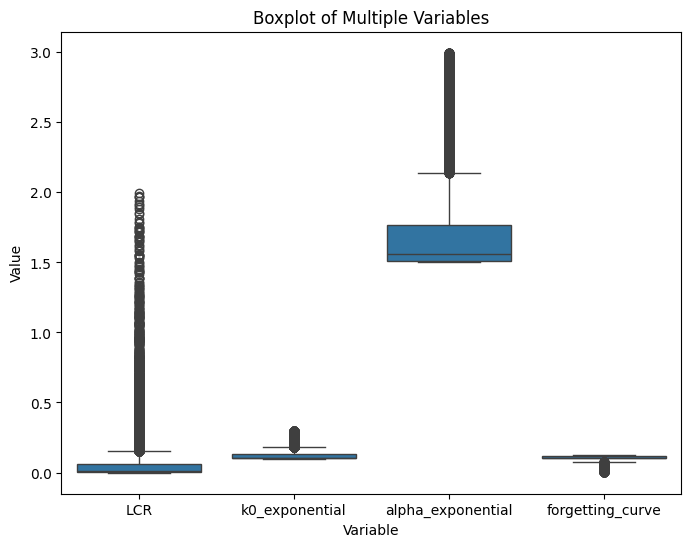

In [150]:
plt.figure(figsize=(15,10))

tmp_melted = pd.melt(tmp, value_vars=['LCR', 'k0_exponential', 'alpha_exponential', 'forgetting_curve'], 
                     var_name='Variable', value_name='Value')

# Seaborn boxplot 그리기
plt.figure(figsize=(8, 6))
sns.boxplot(x='Variable', y='Value', data=tmp_melted)
plt.title('Boxplot of Multiple Variables')
plt.show()

In [158]:
tmp['LCR'].describe()

count    184466.000000
mean          0.045799
std           0.077119
min           0.000014
25%           0.002557
50%           0.012855
75%           0.064209
max           1.495653
Name: LCR, dtype: float64

회귀 계수: [-0.31044342  0.01671615  0.12537111]
절편: -0.08731506724204349
Mean Squared Error: 1.923690416806914e-05


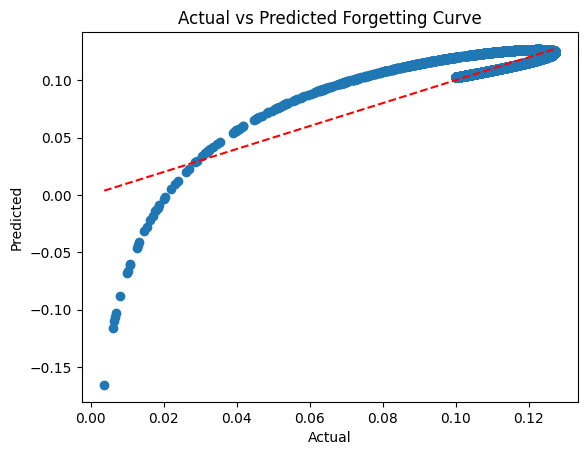

In [164]:
# 독립 변수(X)와 종속 변수(y)
X = tmp[['LCR', 'k0_exponential', 'alpha_exponential']]  # 독립 변수
y = tmp['forgetting_curve']  # 종속 변수

# 데이터 분할 (훈련용/테스트용 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 회귀 분석 결과 출력
print("회귀 계수:", model.coef_)
print("절편:", model.intercept_)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# 예측 결과와 실제 결과 비교 (시각화)
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Forgetting Curve")
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# 예시 데이터 (이미 구한 데이터로 대체 가능)
# 독립변수 (LCR, k0_exponential, alpha_exponential)
X = tmp[['LCR', 'k0_exponential', 'alpha_exponential']]

# 종속변수 (forgetting_curve)
y = tmp['forgetting_curve']

# statsmodels에서는 독립변수에 상수항(절편)을 추가해야 함
X = sm.add_constant(X)  # 상수항 추가

# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 분석 결과 출력
print(model.summary())

ModuleNotFoundError: No module named 'statsmodels'